In [349]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [384]:
df = pd.read_csv("samples.csv").drop("Unnamed: 0", axis = 1)
df.head(10)

,beta,date,climber_id,route_info,comment,label
0,1,"20 Jul, 2019",204193,Dirty_Dick_VS_4b,Starts with nice protection then has one hell ...,0
1,1,"22 Jul, 2005",30255,Side_Face_HVD_3c,Good practice for climbing at places like The ...,0
2,1,"2 Jun, 2019",748,Conchubair_E2_5c,"Steep grass and heather approaching the base, ...",0
3,1,"15 Mar, 2007",8727,The_Sentinel_E2_5b,Good mid-grade E2 5b with plenty of good cams ...,1
4,1,"1 Aug, 2002",20,Obsession_Fatale_E8_6c,Oli! Do tell more?....!,0
5,1,"4 May, 2019",234845,The_Russian_HVS_5a,Some fine polishing. Hard to smear too.,0
6,1,"20 Feb, 2002",14967,Obsession_Fatale_E8_6c,"On a cold dry day, shocking straight forward.....",0
7,1,"16 May, 2005",2637,Slab_and_Crack_D,"Led this earlier today, good fun - bet it's ho...",0
8,1,"4 Apr, 2007",90264,Limbo_S_4a,"I agree, a good warm up, or try the thinner fi...",0
9,1,"2 Sep, 2019",104958,The_Asp_E3_6a,The move to the pocket is a bit scary but afte...,0


In [351]:
df['label'] = df['label'].map(lambda x: str(x)[0] if len(str(x))>1 else str(x))

In [352]:
X_train, X_test, y_train, y_test = train_test_split(
        df['comment'], df['label'], random_state = 1,
        test_size = 0.25, stratify = df['label'])

In [353]:
df['comment_len'] = df['comment'].map(len)

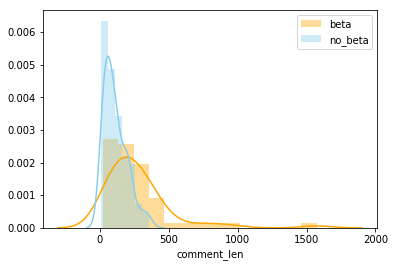

In [354]:
sns.distplot(df[df['label'] == '1']['comment_len'],color='orange')
sns.distplot(df[df['label'] == '0']['comment_len'],color='skyblue')
plt.legend(['beta', 'no_beta'])
plt.show()

In [376]:
asm_vect = TfidfVectorizer(
    ngram_range = (1,4), min_df = 5, stop_words = 'english')

X_train_vect = asm_vect.fit_transform(X_train)
X_test_vect = asm_vect.transform(X_test)

clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train_vect.toarray(), y_train)

pred = clf.predict(X_test_vect.toarray())
print(metrics.classification_report(y_test, pred, target_names = ['no_beta', 'beta']))

              precision    recall  f1-score   support

     no_beta       0.79      0.90      0.84        21
        beta       0.83      0.67      0.74        15

    accuracy                           0.81        36
   macro avg       0.81      0.79      0.79        36
weighted avg       0.81      0.81      0.80        36



In [356]:
vect = CountVectorizer(ngram_range = (2,3), stop_words = 'english')
vect = vect.fit(df.comment.apply("".join))
beta = vect.transform(df[df['label']=='1'].comment)
no_beta = vect.transform(df[df['label']=='0'].comment)

In [357]:
beta_grams = beta.sum(axis = 0)
no_beta_grams = no_beta.sum(axis = 0)
beta_grams_freq = [(gram, beta_grams[0, idx]) for gram, idx in vect.vocabulary_.items()]
no_beta_grams_freq = [(gram, no_beta_grams[0, idx]) for gram, idx in vect.vocabulary_.items()]
beta_gf = pd.DataFrame(list(sorted(beta_grams_freq, key = lambda x: x[1], reverse=True)),columns=['terms','beta'])
no_beta_gf = pd.DataFrame(list(sorted(no_beta_grams_freq, key = lambda x: x[1], reverse=True)),columns=['terms','no_beta'])

In [358]:
beta_gf_df = beta_gf.set_index("terms")
no_beta_gf_df = no_beta_gf.set_index("terms")
comment_gram_df = pd.concat([no_beta_gf_df,beta_gf_df],axis = 1, sort = False)

In [359]:
comment_gram_df['dif'] = comment_gram_df['beta'] - comment_gram_df['no_beta']

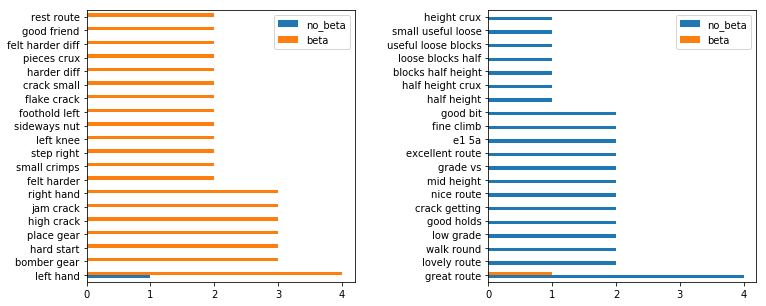

In [360]:
f, axarr = plt.subplots(1, 2,figsize=(12, 5))
comment_gram_df.sort_values(by ='dif', ascending = False)[['no_beta','beta']][:20].plot.barh(ax=axarr[0])
comment_gram_df.sort_values(by ='dif', ascending = False)[['no_beta','beta']][::-1][:20].plot.barh(ax=axarr[1])
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [381]:
beta = ["theres a good green cam at the crux, you can back up the pegs below the roof with a micro cam",
        "match the block, put a cam in on the left and build your feet. put your foot in the bore hole",
        "don't put a gold cam in the hand jam"]

not_beta = ["really good route, beautiful", 
            "great day out with my Bill", 
            "absolutely awful, stay well away from this route, its no fun. "]


In [382]:
clf.predict(asm_vect.transform(beta))

array(['1', '1', '1'], dtype=object)

In [383]:
clf.predict(asm_vect.transform(not_beta))

array(['0', '0', '0'], dtype=object)